#### Importing Libraries

In [1]:
# import all libraries needed
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam, SGD, Adagrad, Adamax, RMSprop
from sklearn.metrics import classification_report
import os
import zipfile
import shutil
import splitfolders
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPool2D, SpatialDropout2D, BatchNormalization, AveragePooling2D, GlobalAvgPool2D, Dropout
from sklearn.preprocessing import LabelEncoder

In [2]:
data_dir = 'C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/dataset'
output = 'C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/dataset_split'
splitfolders.ratio(data_dir, output=output, seed=42, ratio=(0.7, 0.3)) 

Copying files: 13808 files [00:18, 735.70 files/s]


In [3]:
train_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train')
validation_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/val')

In [4]:
# gather train dataset
trainX = []
trainY = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            trainX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            trainY.append(label)

trainX = np.array(trainX)
trainY = np.array(trainY)

In [5]:
# gather validation data
valX = []
valY = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            valX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            valY.append(label)

valX = np.array(valX)
valY = np.array(valY)

In [6]:
# check shape of each images in train & val dataset
print("Train Data=", trainX.shape)
print("Train Label=", trainY.shape)
print("Validation Data=", valX.shape)
print("Validation Label=", valY.shape)
     

Train Data= (2183, 150, 150, 3)
Train Label= (2183,)
Validation Data= (702, 150, 150, 3)
Validation Label= (702,)


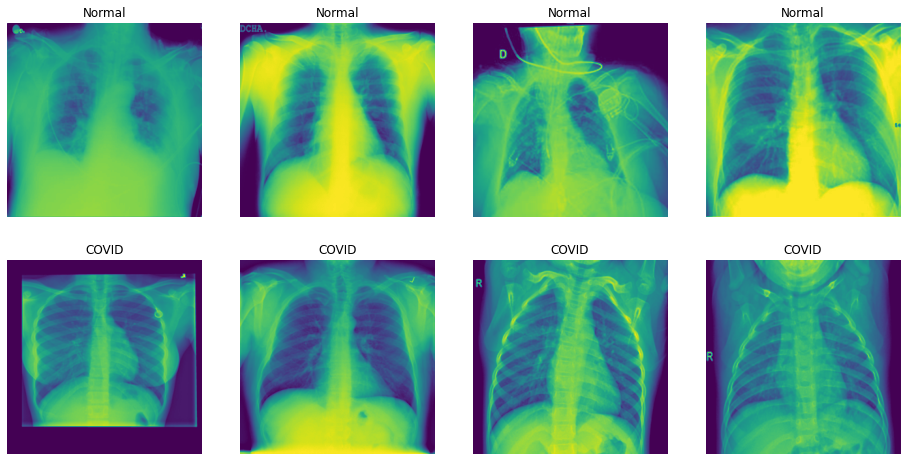

In [7]:
%matplotlib inline


train_COVID_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/dataset_split/train/COVID')
train_Normal_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/dataset_split/train/Normal')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 4

next_COVID_pix = [os.path.join(train_COVID_dir, fname)
                        for fname in os.listdir(train_COVID_dir)[pic_index-4:pic_index]]
next_Normal_pix = [os.path.join(train_Normal_dir, fname)
                       for fname in os.listdir(train_Normal_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_COVID_pix+next_Normal_pix):
    # Set up subplot; subplot indices start at 1
    if(i < 4) :
        title = "Normal"
    else:
        title = "COVID"
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.title(title)
    img = mpimg.imread(img_path)
    plt.imshow(img)


plt.show()

In [8]:
# label encoder implementation in each train & validation label
lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)

In [9]:
# normalize the scale in every images using ImageDataGenerator
datagen = ImageDataGenerator( rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)
# implement ImageDataGenerator in train, test data, & each label
train_iterator = datagen.flow(trainX, trainY, batch_size=64)
val_iterator = datagen.flow(valX, valY, batch_size=64)
print('Batches train=%d, validation=%d' % (len(train_iterator), len(val_iterator)))

Batches train=35, validation=11


In [10]:
# check maximum & minimum scale of each images
print('Train min=%.f, max=%.f' % (trainX.min(), trainX.max()))
print('Validation min=%.f, max=%.f' % (valX.min(), valX.max()))
     

Train min=0, max=255
Validation min=0, max=255


In [11]:
# check minimum & maximum scale after normalize each images
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 150, 150, 3), min=0.000, max=1.000


Model 1

In [19]:
model = Sequential()
model.add(InputLayer(input_shape=[150, 150, 3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Flatten())

# fully connected
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                      

In [20]:
# compile model
model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# training & saving history of every epoch
H = model.fit(train_iterator, epochs=100, validation_data=val_iterator, verbose=1)

Epoch 1/100
35/35 [==============================] - 44s 1s/step - loss: 0.7681 - accuracy: 0.3472 - val_loss: 0.6338 - val_accuracy: 0.3746
Epoch 2/100
35/35 [==============================] - 46s 1s/step - loss: 0.6176 - accuracy: 0.3578 - val_loss: 0.5286 - val_accuracy: 0.3419
Epoch 3/100
35/35 [==============================] - 48s 1s/step - loss: 0.5254 - accuracy: 0.3541 - val_loss: 0.5418 - val_accuracy: 0.3504
Epoch 4/100
35/35 [==============================] - 45s 1s/step - loss: 0.4906 - accuracy: 0.3784 - val_loss: 0.5158 - val_accuracy: 0.3504
Epoch 5/100
35/35 [==============================] - 45s 1s/step - loss: 0.4400 - accuracy: 0.3935 - val_loss: 0.3565 - val_accuracy: 0.3504
Epoch 6/100
35/35 [==============================] - 46s 1s/step - loss: 0.3864 - accuracy: 0.3697 - val_loss: 0.3614 - val_accuracy: 0.3689
Epoch 7/100
35/35 [==============================] - 45s 1s/step - loss: 0.3840 - accuracy: 0.3852 - val_loss: 0.3516 - val_accuracy: 0.3447
Epoch 8/100
3

In [22]:
model.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 1.h5')

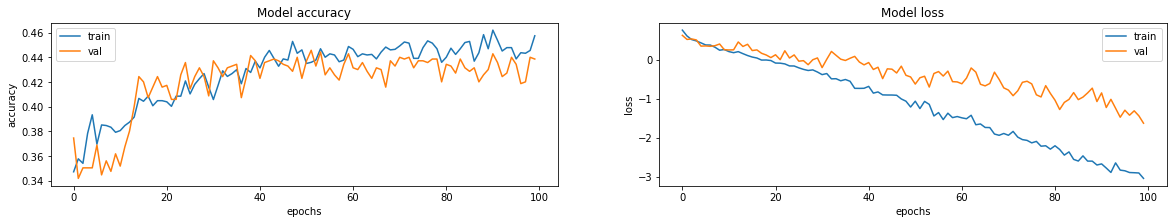

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
# classification report
pred = model.predict(trainX)
labels = (pred > 0.5).astype(np.int)
print(classification_report(trainY, labels))

69/69 [==============================] - 6s 89ms/step
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       700
           1       0.37      0.77      0.50       678
           2       0.00      0.00      0.00       805

    accuracy                           0.49      2183
   macro avg       0.37      0.52      0.42      2183
weighted avg       0.35      0.49      0.40      2183



<ipython-input-36-e60bd2374c68>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = (pred > 0.5).astype(np.int)
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision a

In [24]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [27]:
# build a simple model
model2 = Sequential()
model2.add(InputLayer(input_shape=[150, 150, 3]))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())
model2.add(GlobalAvgPool2D())
model2.add(Flatten())

# fully connected
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 spatial_dropout2d_7 (Spatia  (None, 150, 150, 16)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_8 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 150, 150, 32)     

In [30]:
model2.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# training & saving history of every epoch
H2 = model2.fit(train_iterator, epochs=100, validation_data=val_iterator, verbose=1)

Epoch 1/100
35/35 [==============================] - 137s 4s/step - loss: 0.8351 - accuracy: 0.2987 - val_loss: 0.6349 - val_accuracy: 0.3105
Epoch 2/100
35/35 [==============================] - 137s 4s/step - loss: 0.7075 - accuracy: 0.3335 - val_loss: 0.5911 - val_accuracy: 0.3105
Epoch 3/100
35/35 [==============================] - 140s 4s/step - loss: 0.6025 - accuracy: 0.3463 - val_loss: 0.5488 - val_accuracy: 0.3105
Epoch 4/100
35/35 [==============================] - 139s 4s/step - loss: 0.5756 - accuracy: 0.3532 - val_loss: 0.5066 - val_accuracy: 0.3105
Epoch 5/100
35/35 [==============================] - 146s 4s/step - loss: 0.5675 - accuracy: 0.3472 - val_loss: 0.4745 - val_accuracy: 0.3105
Epoch 6/100
35/35 [==============================] - 159s 5s/step - loss: 0.4944 - accuracy: 0.3669 - val_loss: 0.4442 - val_accuracy: 0.3105
Epoch 7/100
35/35 [==============================] - 161s 5s/step - loss: 0.4859 - accuracy: 0.3610 - val_loss: 0.4111 - val_accuracy: 0.3105
Epoch 

In [33]:
model.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 2.h5')

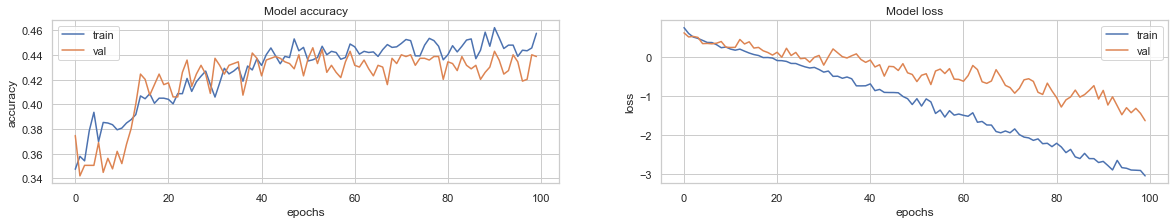

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
# classification report
pred = model2.predict(trainX)
labels = (pred > 0.5).astype(np.int)
print(classification_report(trainY, labels))

69/69 [==============================] - 22s 307ms/step
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       700
           1       0.00      0.00      0.00       678
           2       0.00      0.00      0.00       805

    accuracy                           0.32      2183
   macro avg       0.11      0.33      0.16      2183
weighted avg       0.10      0.32      0.16      2183



<ipython-input-35-aa367d2d882d>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = (pred > 0.5).astype(np.int)
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision a